#<h1><font color="#110068" size=5> TFE</font></h1>


<h1><font color="#110068" size=6>Modelo de redes convolucionales para la detección de Patologías oculares mediante el procesamiento de imágenes </font></h1>

<div style="text-align: right">
<font size=3> </font><br>
ALUMNO 1: Margarita Cardenas  </font><br>
ALUMNO 2: Miguel Rojas </font><br>
ALUMNO 3: Walter Vega </font><br>

</font><br>
<font size=3>TFE:
Implementar una Inteligencia Artificial para la detección de patologías oculares mediante el procesamiento de imágenes
</font><br>
<font size=3>UNIR</font>
</div>

# Instalación de complementos y librerias necesarias

In [ ]:
!pip install pydrive2

## Descargamos el dataset de imágenes (Desde una carpeta compartida en GoogleDrive) y descomprimimos el conjunto de imágenes con los que vamos a trabajar

In [ ]:
import os

from pydrive2.auth import GoogleAuth
from google.colab import drive as colab_drive
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

# Autenticar el usuario
auth.authenticate_user()

# Inicializar GoogleAuth y establecer las credenciales
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()

# Crear la instancia de GoogleDrive
drive = GoogleDrive(gauth)

file_id = '1KXCIri7VEdjwCnTPocehAf73z_7jgbgF'

if (not os.path.exists("/content/DS_TFE_final.zip")):
  download = drive.CreateFile({'id': file_id})
  # Download the file to a local disc
  download.GetContentFile('DS_TFE_final.zip')
  !unzip "/content/DS_TFE_final.zip"



Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR273.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR274.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR275.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR277.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR278.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR280.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR281.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR282.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR283.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR286.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR288.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR289.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR29.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR290.jpg  
  inflating: DS_TFE_Final/trai

## Importación de librerías necesarias para el notebook

In [ ]:
import pandas
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, MaxPooling2D, Flatten, Conv2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn
import cv2

import glob
import re

Carga de las variables con los directores donde se encuentran las imágenes de entrenamiento, validación y prueba

In [ ]:
train_dir = '/content/DS_TFE_Final/train'
test_dir = '/content/DS_TFE_Final/test'
val_dir = '/content/DS_TFE_Final/val'

Chequeo de cantidad de imágenes cargadas en cada directorio.

In [ ]:
cataract_images = glob.glob(train_dir+"/Cataract/*.jpg")
diabetic_retinopathy_images = glob.glob(train_dir+"/Diabetic_Retinopathy/*.jpg")
glaucoma_images = glob.glob(train_dir+"/Glaucoma/*.jpg")
healthy_images = glob.glob(train_dir+"/Healthy/*.jpg")
macular_scar_images = glob.glob(train_dir+"/Macular_Scar/*.jpg")
myopia_images = glob.glob(train_dir+"/Myopia/*.jpg")

print(len(cataract_images))
print(len(diabetic_retinopathy_images))
print(len(glaucoma_images))
print(len(healthy_images))
print(len(macular_scar_images))
print(len(myopia_images))

732
1056
944
717
933
1050


## Generamos un grafico de torta para ver la cantidad de imagenes

De esta forma se puede observar la distribución de clases y el balanceo de clases.

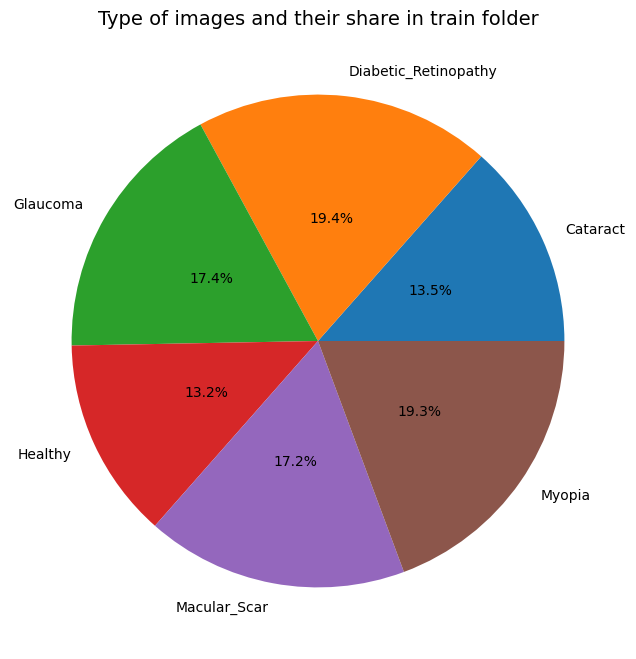

In [ ]:
plt.figure(figsize=(8, 8))
plt.pie(x=np.array([len(cataract_images), len(diabetic_retinopathy_images), len(glaucoma_images),
                    len(healthy_images), len(macular_scar_images),len(myopia_images)
                    ]), autopct="%.1f%%", labels=["Cataract", "Diabetic_Retinopathy", "Glaucoma",
                                                  "Healthy", "Macular_Scar", "Myopia"], pctdistance=0.5)
plt.title("Type of images and their share in train folder", fontsize=14);

## Visualizamos algunas de las imagenes del dataset

In [ ]:
def show_6_images(vector_imagenes, filtro, titulo):
  fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(10,10), subplot_kw={'xticks':[], 'yticks':[]})
  for i, ax in enumerate(axes.flat):
      img = cv2.imread(vector_imagenes[i])
      img = cv2.resize(img, (220,220))
      if (filtro =="Canny"):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.Canny(img, 80, 100)
      ax.imshow(img)
      ax.set_title(titulo)
  fig.tight_layout()
  plt.show()

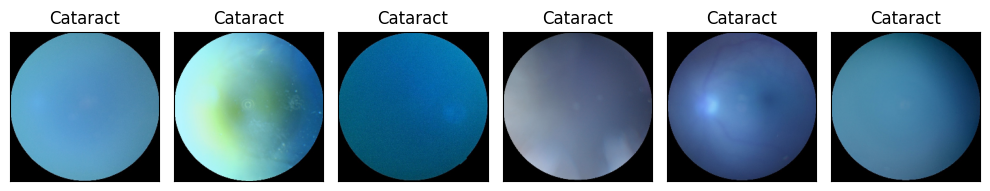

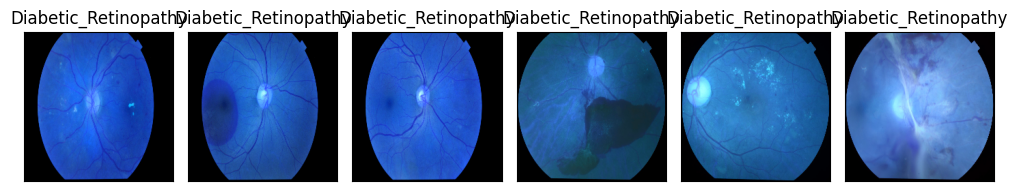

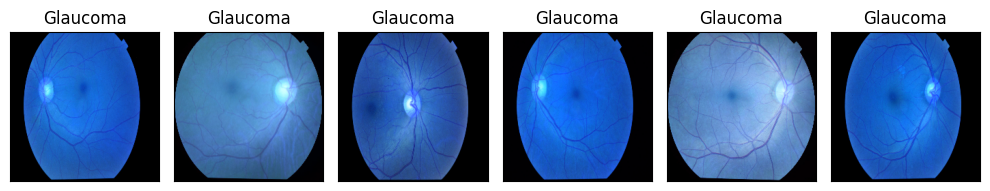

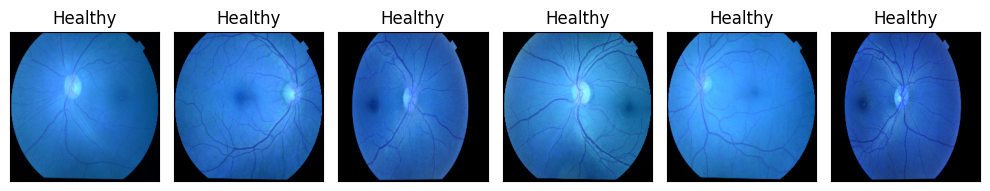

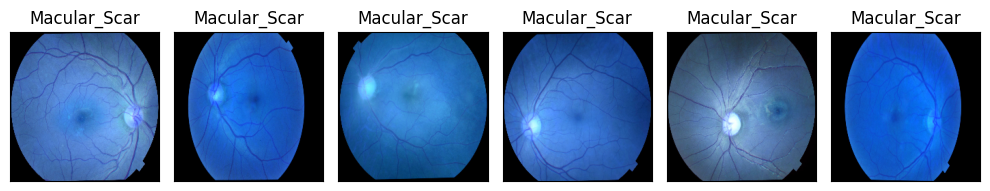

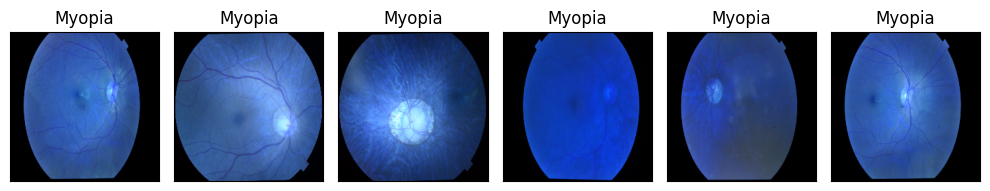

In [ ]:
show_6_images(cataract_images, "", "Cataract")
show_6_images(diabetic_retinopathy_images, "", "Diabetic_Retinopathy")
show_6_images(glaucoma_images, "", "Glaucoma")
show_6_images(healthy_images, "", "Healthy")
show_6_images(macular_scar_images, "", "Macular_Scar")
show_6_images(myopia_images, "", "Myopia")


## Creación de los generadores de imágenes mediante el objeto ImageDataGenerator

Este objeto permite procesar batches con una cantidad determinada de imágenes con normalización X/255, desde los directorios definidos anteriormente.

El batch definido es de 20 y al tratarse de un algoritmo de clasificación multiclase se utiliza el parámetro class_mode como categorical.

Adicionalmente se define el tamaño de las imagenes a procesar como (224,224)

El input_shape para el modelo indica el largo y ancho de las imagenes así como también la cantidad de dimensiones.
En este caso se ajusta a los modelos pre entrenados donde la mayoría acepta tamaños de 224,224 de 3 dimensiones (correspondiente a los canales RGB)
En algunas de las redes esta variable se debe redefinir para el tamaño correcto para diche red preentrenada


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   zoom_range = 0.2)
val_datagen = ImageDataGenerator(rescale = 1./255.,)
test_datagen = ImageDataGenerator(rescale = 1./255.,)


train_generator = train_datagen.flow_from_directory(train_dir, batch_size=20, class_mode='categorical', target_size = (224, 224))
validation_generator = val_datagen.flow_from_directory(val_dir, shuffle=False, batch_size=20, class_mode = 'categorical', target_size=(224, 224))
test_generator = test_datagen.flow_from_directory(test_dir, batch_size=20, class_mode = 'categorical', target_size=(224, 224))

Found 5432 images belonging to 6 classes.
Found 775 images belonging to 6 classes.
Found 1554 images belonging to 6 classes.


In [ ]:
input_shape = (224, 224, 3)

## Preparamos la configuración para todos los graficos que vamos a utilizar

La siguiente función permite graficar los valores de accuracy, perdida, recall y auc

In [ ]:
def graph(h):
    accuracy = h.history['accuracy']
    val_accuracy  = h.history['val_accuracy']

    loss = h.history['loss']
    val_loss = h.history['val_loss']

    precision = h.history['precision']
    val_precision = h.history['val_precision']

    recall = h.history['recall']
    val_recall = h.history['val_recall']

    auc = h.history['auc']
    val_auc = h.history['val_auc']

    plt.figure(figsize=(15,15))

    plt.subplot(4, 4, 1)
    plt.plot(accuracy, label = "Training accuracy")
    plt.plot(val_accuracy, label="Validation accuracy")
    plt.ylim(0, 1)
    plt.legend()
    plt.title("Training vs validation accuracy")


    plt.subplot(4,4,2)
    plt.plot(loss, label = "Training loss")
    plt.plot(val_loss, label="Validation loss")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation loss")

    plt.subplot(4,4,3)
    plt.plot(precision, label = "Training Precisión")
    plt.plot(val_precision, label="Validation Precisión")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation Precisión")

    plt.subplot(4,4,4)
    plt.plot(recall, label = "Training Recall")
    plt.plot(val_recall, label="Validation Recall")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation Recall")

    plt.show()

    plt.figure(figsize=(15,15))

    plt.subplot(4,4,1)
    plt.plot(auc, label = "Training auc")
    plt.plot(val_auc, label="Validation auc")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation auc")

    plt.show()

La siguiente función permite graficar los valores de accuracy, perdida, recall y auc

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
def cf_matrix(y_pred_test, y_test, y_pred_val, y_val):
  y_true_test = y_test
  y_pred_test_classes = np.argmax(y_pred_test, axis=1)

  y_true_val = y_val
  y_pred_val_classes = np.argmax(y_pred_val, axis=1)

# Create a confusion matrix
  cm_test = confusion_matrix(y_test, y_pred_test_classes)
  cm_val = confusion_matrix(y_val, y_pred_val_classes)
  Etq = ["Cataract", "D_Retinopathy", "Glaucoma", "Healthy", "M_Scar", "Myopia"]

# Plot the confusion matrix
  plt.rcParams["figure.figsize"] = [9.50, 4.50]
  plt.rcParams["figure.autolayout"] = True

  fig, (ax1, ax2) = plt.subplots(ncols=2)
  fig.subplots_adjust(wspace=0.01)
  ax1.set_title('Confusion Matrix - Test')
  sns.heatmap(cm_test, annot=True,fmt='d', cmap='YlGnBu', ax=ax1, xticklabels=Etq, yticklabels=Etq)
  ax2.set_title('Confusion Matrix - Val')
  sns.heatmap(cm_val, annot=True,fmt='d', cmap='YlGnBu', ax=ax2, xticklabels=Etq, yticklabels=Etq)

  fig.subplots_adjust(wspace=1)
  plt.xlabel('Predicción')
  plt.ylabel('Real')
  plt.show()


La siguiente función permite visualizar la matriz de confusión de una forma visualmente amigable

In [ ]:
from sklearn.metrics import classification_report

def calcular_metricas_por_clase(modelo, y_pred, y):
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Generar el reporte de clasificación
    reporte = classification_report(y, y_pred_classes)
    return reporte



La siguiente función permite evaluar el modelo utilizando el método evaluate propio de la librería

In [ ]:
def evaluar_modelo(modelo):
  print("Evaluar con Entrenamiento:")
  modelo.evaluate(train_generator)
  print("Evaluar con Validación:")
  modelo.evaluate(test_generator)
  print("Evaluar con Prueba:")
  modelo.evaluate(validation_generator)

# Definición de Modelos

## Modelo 1

In [ ]:
model1 = Sequential()
model1.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model1.add(MaxPooling2D())
model1.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model1.add(MaxPooling2D())
model1.add(Conv2D(64, kernel_size=(2, 2), activation='relu'))
model1.add(MaxPooling2D())
model1.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model1.add(MaxPooling2D())
model1.add(Conv2D(32, kernel_size=(2, 2), activation='relu'))
model1.add(MaxPooling2D())
model1.add(Flatten())
model1.add(Dense(128, activation = 'relu'))
model1.add(Dropout(0.2))
model1.add(Dense(6, activation='softmax'))
model1.summary()

model1.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history1 = model1.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 128)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 53, 53, 64)        16448     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 64)       

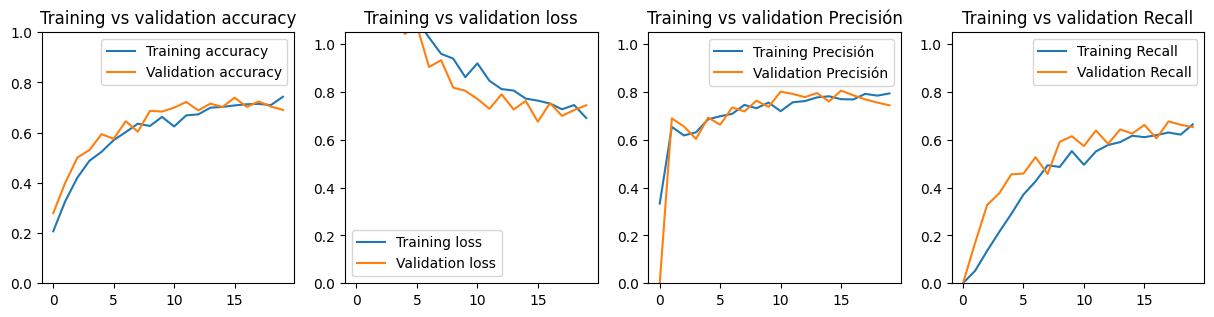

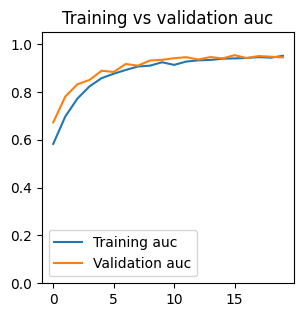

In [ ]:
graph(history1)

In [ ]:
y_pred1_test = model1.predict(test_generator)
y_pred1_val = model1.predict(validation_generator)

39/39 [==============================] - 12s 319ms/step


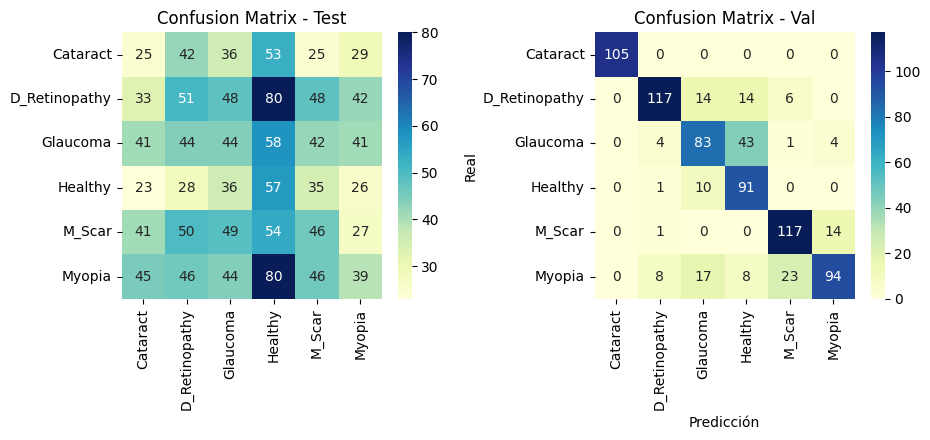

In [ ]:
cf_matrix(y_pred1_test, test_generator.classes, y_pred1_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model1, y_pred1_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model1, y_pred1_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.12      0.12      0.12       210
           1       0.20      0.17      0.18       302
           2       0.17      0.16      0.17       270
           3       0.15      0.28      0.19       205
           4       0.19      0.17      0.18       267
           5       0.19      0.13      0.15       300

    accuracy                           0.17      1554
   macro avg       0.17      0.17      0.17      1554
weighted avg       0.17      0.17      0.17      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.89      0.77      0.83       151
           2       0.67      0.61      0.64       135
           3       0.58      0.89      0.71       102
           4       0.80      0.89      0.84       132
           5       0.84      0.63      0.72       150

    accuracy                           0.78       775
   macro avg       0.80

## Modelo 4

In [ ]:
model4 = Sequential()
model4.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model4.add(MaxPooling2D())
model4.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model4.add(MaxPooling2D())
model4.add(Conv2D(64, kernel_size=(2, 2), activation='relu'))
model4.add(MaxPooling2D())
model4.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model4.add(MaxPooling2D())
model4.add(Conv2D(32, kernel_size=(2, 2), activation='relu'))
model4.add(MaxPooling2D())
model4.add(Flatten())
model4.add(Dense(256, activation = 'relu'))
model4.add(Dense(128, activation = 'relu'))
model4.add(Dense(6, activation='softmax'))
model4.summary()

model4.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history4 = model4.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback) #

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 111, 111, 128)     0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 109, 109, 64)      73792     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 53, 53, 64)        16448     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 26, 26, 64)       

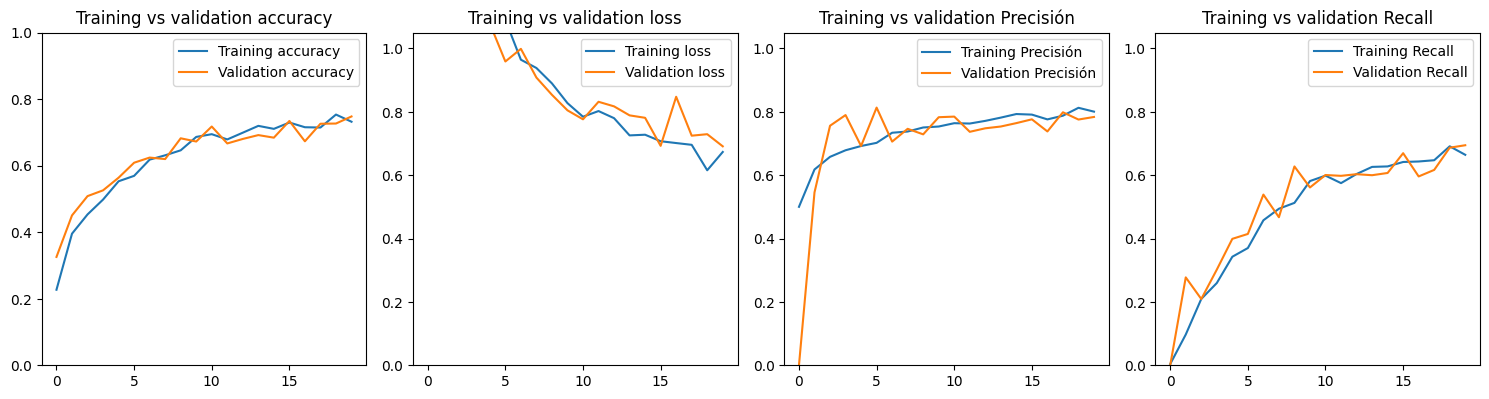

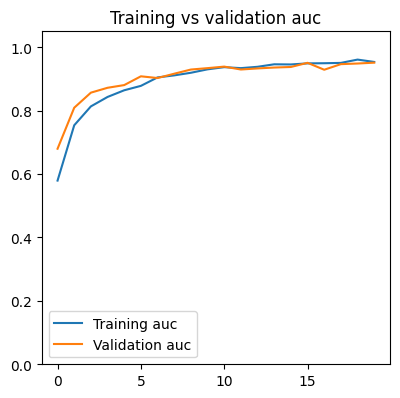

In [ ]:
graph(history4)

In [ ]:
y_pred4_test = model4.predict(test_generator)
y_pred4_val = model4.predict(validation_generator)

39/39 [==============================] - 11s 297ms/step


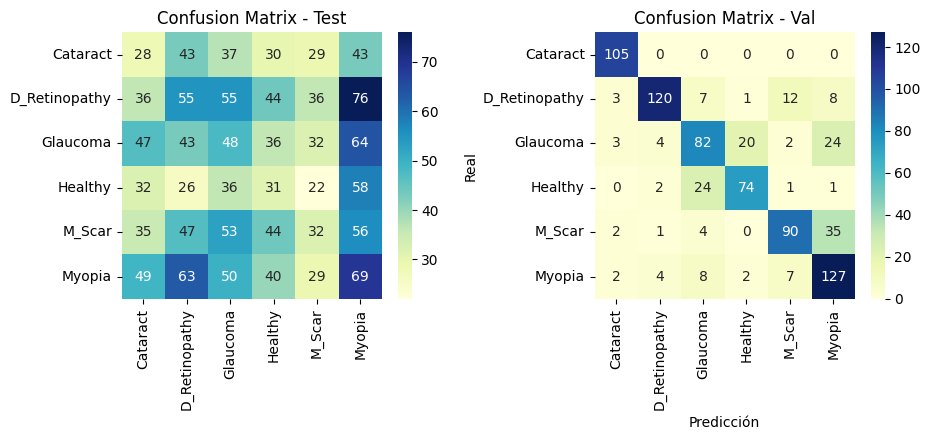

In [ ]:
cf_matrix(y_pred4_test, test_generator.classes, y_pred4_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model4, y_pred4_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model4, y_pred4_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.12      0.13      0.13       210
           1       0.20      0.18      0.19       302
           2       0.17      0.18      0.17       270
           3       0.14      0.15      0.14       205
           4       0.18      0.12      0.14       267
           5       0.19      0.23      0.21       300

    accuracy                           0.17      1554
   macro avg       0.17      0.17      0.16      1554
weighted avg       0.17      0.17      0.17      1554

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       105
           1       0.92      0.79      0.85       151
           2       0.66      0.61      0.63       135
           3       0.76      0.73      0.74       102
           4       0.80      0.68      0.74       132
           5       0.65      0.85      0.74       150

    accuracy                           0.77       775
   macro avg       0.78

## Modelo 5

In [ ]:
model5 = Sequential()
model5.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model5.add(MaxPooling2D())
model5.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model5.add(MaxPooling2D())
model5.add(Conv2D(64, kernel_size=(2, 2), activation='relu'))
model5.add(MaxPooling2D())
model5.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model5.add(MaxPooling2D())
model5.add(Conv2D(32, kernel_size=(2, 2), activation='relu'))
model5.add(MaxPooling2D())
model5.add(Flatten())
model5.add(Dense(2056, activation = 'relu'))
model5.add(Dense(1024, activation = 'relu'))
model5.add(Dense(512, activation = 'relu'))
model5.add(Dense(256, activation = 'relu'))
model5.add(Dense(6, activation='softmax'))
model5.summary()

model5.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history5 = model5.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=30, callbacks=callback)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 128)     0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      73792     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 53, 53, 64)        16448     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 26, 26, 64)       

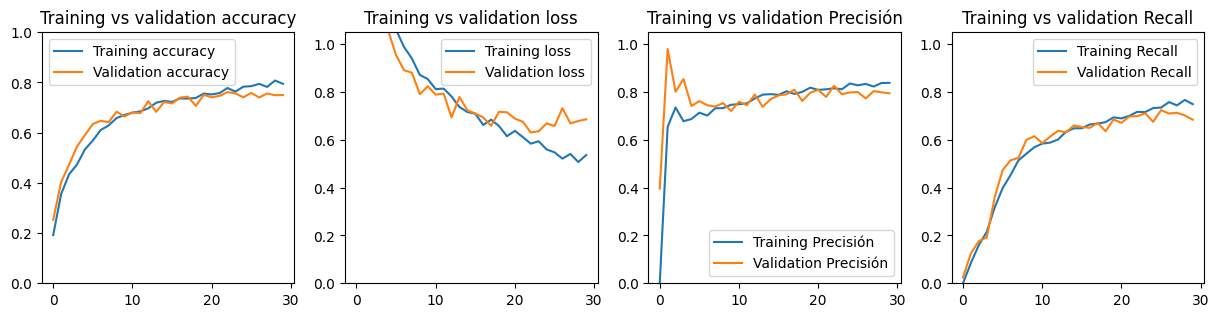

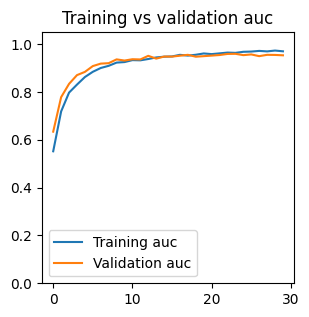

In [ ]:
graph(history5)

In [ ]:
y_pred5_test = model5.predict(test_generator)
y_pred5_val = model5.predict(validation_generator)

39/39 [==============================] - 11s 296ms/step


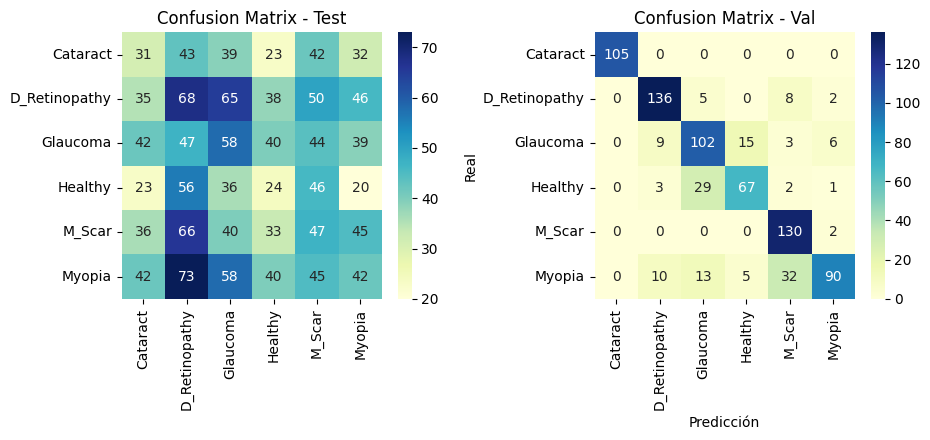

In [ ]:
cf_matrix(y_pred5_test, test_generator.classes, y_pred5_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model5, y_pred5_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model5, y_pred5_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.15      0.15      0.15       210
           1       0.19      0.23      0.21       302
           2       0.20      0.21      0.20       270
           3       0.12      0.12      0.12       205
           4       0.17      0.18      0.17       267
           5       0.19      0.14      0.16       300

    accuracy                           0.17      1554
   macro avg       0.17      0.17      0.17      1554
weighted avg       0.17      0.17      0.17      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.86      0.90      0.88       151
           2       0.68      0.76      0.72       135
           3       0.77      0.66      0.71       102
           4       0.74      0.98      0.85       132
           5       0.89      0.60      0.72       150

    accuracy                           0.81       775
   macro avg       0.82

## Modelo 15

In [ ]:
model15 = Sequential()
model15.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model15.add(MaxPooling2D())
model15.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model15.add(MaxPooling2D())
model15.add(Conv2D(64, kernel_size=(2, 2), activation='relu'))
model15.add(MaxPooling2D())
model15.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model15.add(MaxPooling2D())
model15.add(Conv2D(32, kernel_size=(2, 2), activation='relu'))
model15.add(MaxPooling2D())
model15.add(Flatten())
model15.add(Dense(2056, activation = 'relu'))
model15.add(Dense(1024, activation = 'relu'))
model15.add(Dense(512, activation = 'relu'))
model15.add(Dense(256, activation = 'relu'))
model15.add(Dense(6, activation='softmax'))
model15.summary()

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model15.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history15 = model15.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=25, callbacks=callback)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 111, 111, 128)     0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 109, 109, 64)      73792     
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 53, 53, 64)        16448     
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 26, 26, 64)       

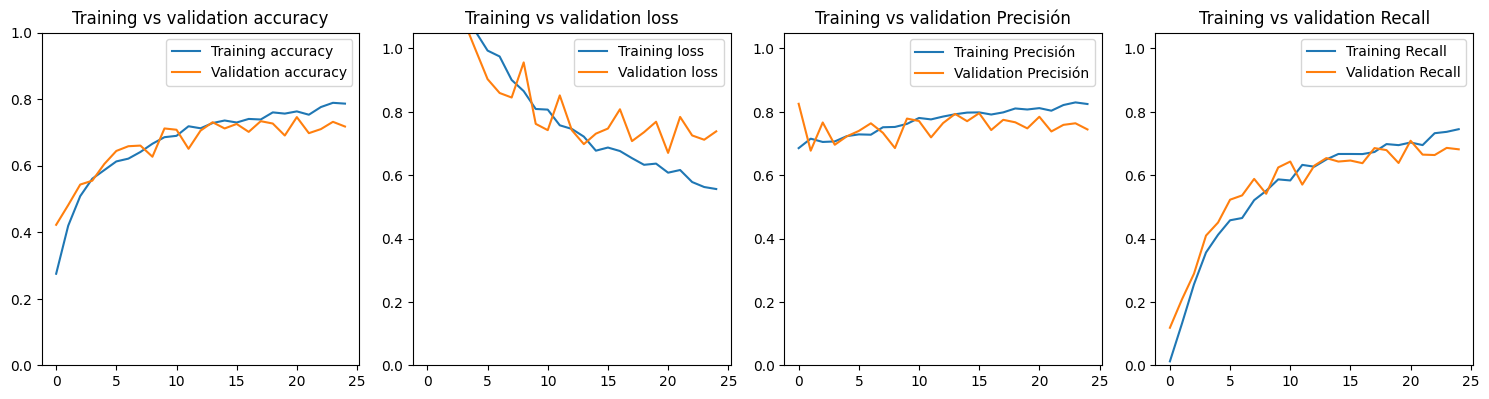

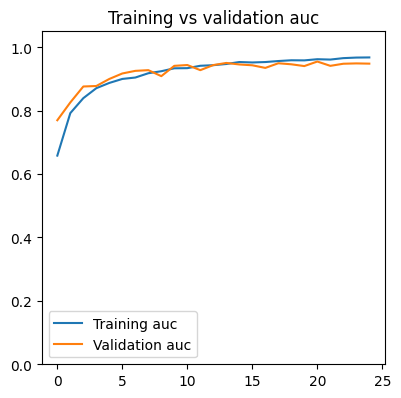

In [ ]:
graph(history15)

39/39 [==============================] - 11s 278ms/step


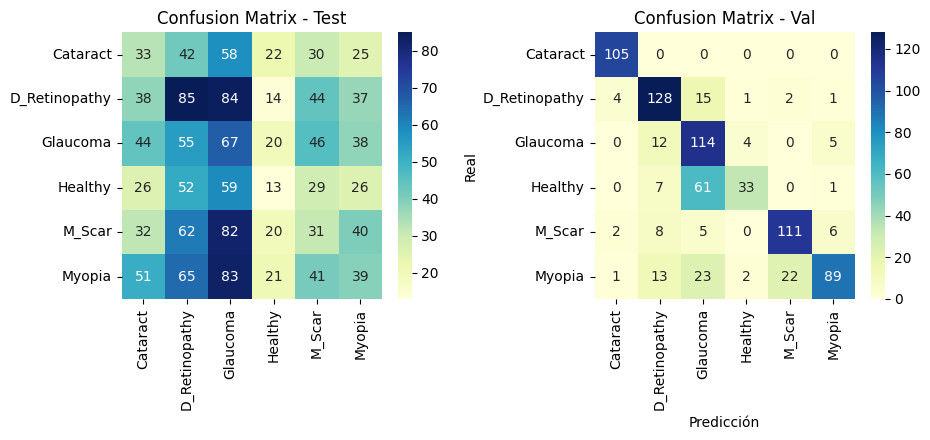

In [ ]:
y_pred15_test = model15.predict(test_generator)
y_pred15_val = model15.predict(validation_generator)
cf_matrix(y_pred15_test, test_generator.classes, y_pred15_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model15, y_pred15_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model15, y_pred15_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.15      0.16      0.15       210
           1       0.24      0.28      0.26       302
           2       0.15      0.25      0.19       270
           3       0.12      0.06      0.08       205
           4       0.14      0.12      0.13       267
           5       0.19      0.13      0.15       300

    accuracy                           0.17      1554
   macro avg       0.16      0.17      0.16      1554
weighted avg       0.17      0.17      0.17      1554

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       105
           1       0.76      0.85      0.80       151
           2       0.52      0.84      0.65       135
           3       0.82      0.32      0.46       102
           4       0.82      0.84      0.83       132
           5       0.87      0.59      0.71       150

    accuracy                           0.75       775
   macro avg       0.79

## Modelo 16

In [ ]:
model16 = Sequential()
model16.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model16.add(MaxPooling2D())
model16.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model16.add(MaxPooling2D())
model16.add(Conv2D(64, kernel_size=(2, 2), activation='relu'))
model16.add(MaxPooling2D())
model16.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model16.add(MaxPooling2D())
model16.add(Conv2D(32, kernel_size=(2, 2), activation='relu'))
model16.add(MaxPooling2D())
model16.add(Flatten())
model16.add(Dense(2056, activation = 'relu'))
model16.add(Dropout(0.2))
model16.add(Dense(1024, activation = 'relu'))
model16.add(Dense(512, activation = 'relu'))
model16.add(Dropout(0.25))
model16.add(Dense(256, activation = 'relu'))
model16.add(Dense(6, activation='softmax'))
model16.summary()

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model16.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history16 = model16.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=25, callbacks=callback)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 111, 111, 128)     0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 109, 109, 64)      73792     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 53, 53, 64)        16448     
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 26, 26, 64)       

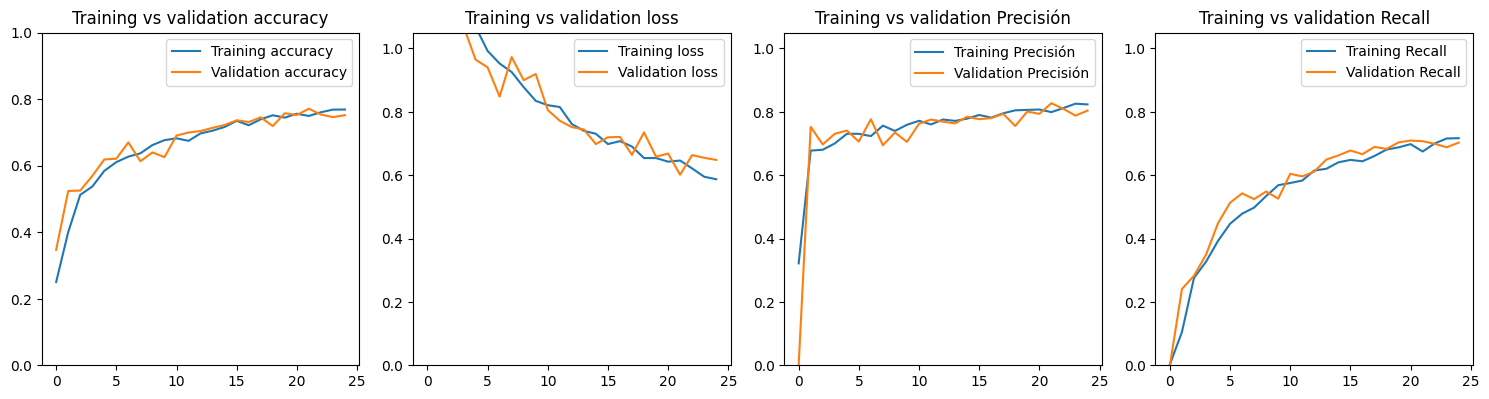

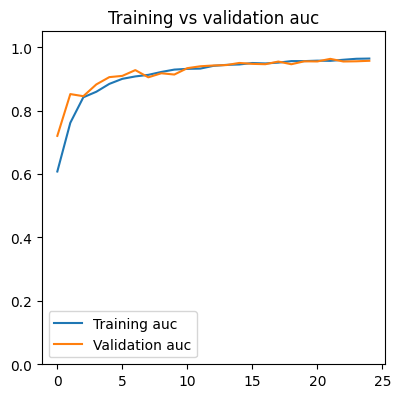

In [ ]:
graph(history16)

39/39 [==============================] - 11s 284ms/step


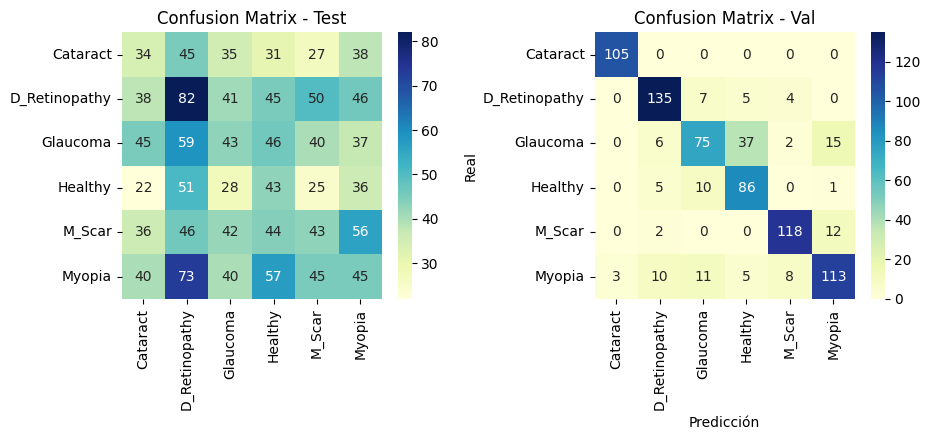

In [ ]:
y_pred16_test = model16.predict(test_generator)
y_pred16_val = model16.predict(validation_generator)
cf_matrix(y_pred16_test, test_generator.classes, y_pred16_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model16, y_pred16_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model16, y_pred16_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.16      0.16      0.16       210
           1       0.23      0.27      0.25       302
           2       0.19      0.16      0.17       270
           3       0.16      0.21      0.18       205
           4       0.19      0.16      0.17       267
           5       0.17      0.15      0.16       300

    accuracy                           0.19      1554
   macro avg       0.18      0.19      0.18      1554
weighted avg       0.19      0.19      0.18      1554

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       105
           1       0.85      0.89      0.87       151
           2       0.73      0.56      0.63       135
           3       0.65      0.84      0.73       102
           4       0.89      0.89      0.89       132
           5       0.80      0.75      0.78       150

    accuracy                           0.82       775
   macro avg       0.82

## Modelo 6

In [ ]:
model6 = Sequential()
model6.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model6.add(MaxPooling2D())
model6.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model6.add(MaxPooling2D())
model6.add(Conv2D(64, kernel_size=(2, 2), activation='relu'))
model6.add(MaxPooling2D())
model6.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model6.add(MaxPooling2D())
model6.add(Conv2D(32, kernel_size=(2, 2), activation='relu'))
model6.add(MaxPooling2D())
model6.add(Flatten())
model6.add(Dense(5112, activation = 'relu'))
model6.add(Dense(2056, activation = 'relu'))
model6.add(Dense(1024, activation = 'relu'))
model6.add(Dense(512, activation = 'relu'))
model6.add(Dense(256, activation = 'relu'))
model6.add(Dense(128, activation = 'relu'))
model6.add(Dense(6, activation='softmax'))
model6.summary()

model6.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history6 = model6.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=30, callbacks=callback)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 111, 111, 128)     0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 109, 109, 64)      73792     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 53, 53, 64)        16448     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 26, 26, 64)       

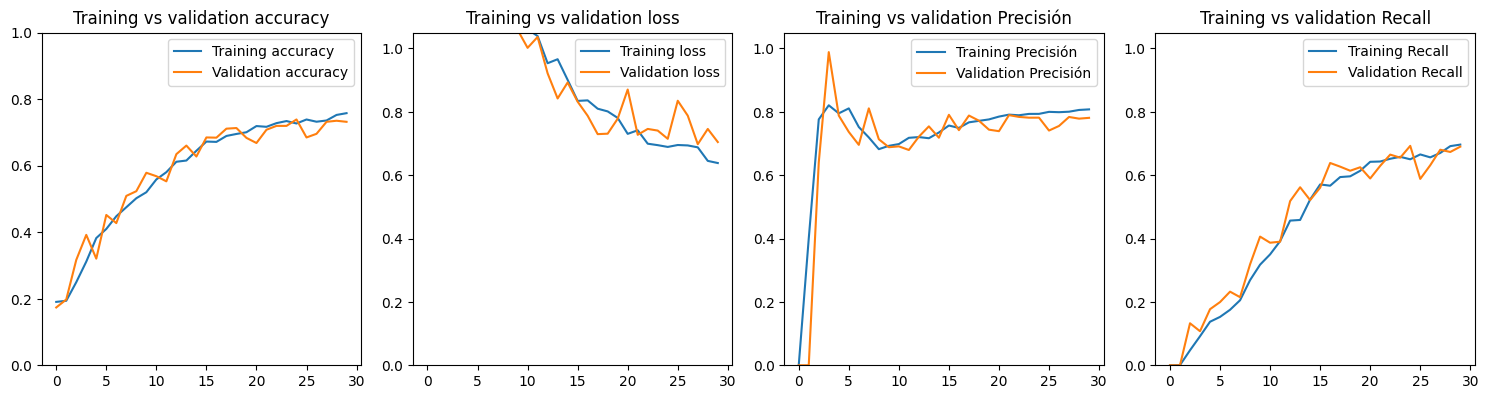

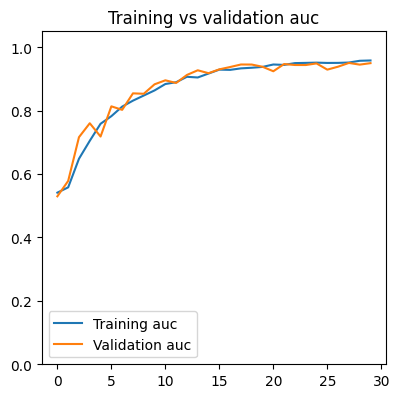

In [ ]:
graph(history6)

In [ ]:
y_pred6_test = model6.predict(test_generator)
y_pred6_val = model6.predict(validation_generator)

39/39 [==============================] - 11s 284ms/step


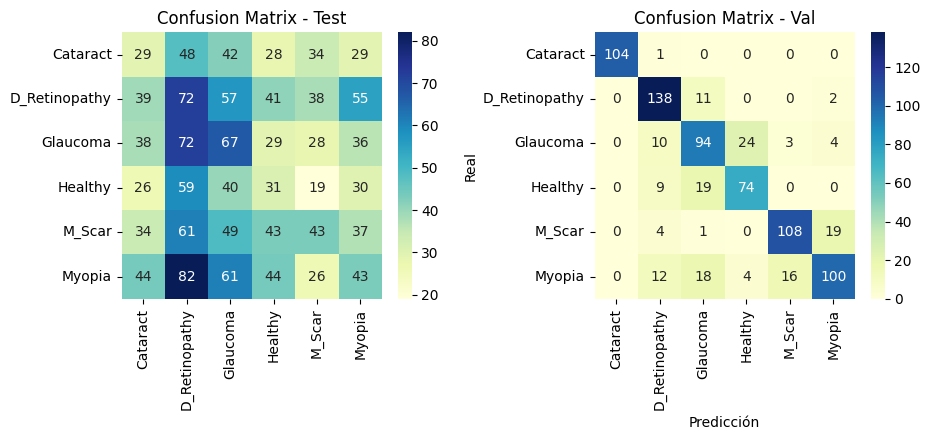

In [ ]:
cf_matrix(y_pred6_test, test_generator.classes, y_pred6_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model6, y_pred6_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model6, y_pred6_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.14      0.14      0.14       210
           1       0.18      0.24      0.21       302
           2       0.21      0.25      0.23       270
           3       0.14      0.15      0.15       205
           4       0.23      0.16      0.19       267
           5       0.19      0.14      0.16       300

    accuracy                           0.18      1554
   macro avg       0.18      0.18      0.18      1554
weighted avg       0.19      0.18      0.18      1554

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       105
           1       0.79      0.91      0.85       151
           2       0.66      0.70      0.68       135
           3       0.73      0.73      0.73       102
           4       0.85      0.82      0.83       132
           5       0.80      0.67      0.73       150

    accuracy                           0.80       775
   macro avg       0.80

## Modelo 20


In [ ]:
model20 = Sequential()
model20.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model20.add(MaxPooling2D())
model20.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model20.add(MaxPooling2D())
model20.add(Conv2D(64, kernel_size=(2, 2), activation='relu'))
model20.add(MaxPooling2D())
model20.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model20.add(MaxPooling2D())
model20.add(Conv2D(32, kernel_size=(2, 2), activation='relu'))
model20.add(MaxPooling2D())
model20.add(Flatten())
model20.add(Dense(512, activation = 'relu'))
model20.add(Dense(6, activation='softmax'))

# Imprimir un resumen del modelo
model20.summary()

# Compilar el modelo
model20.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',  metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
history_dense = model20.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 128)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 53, 53, 64)        16448     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 64)        0

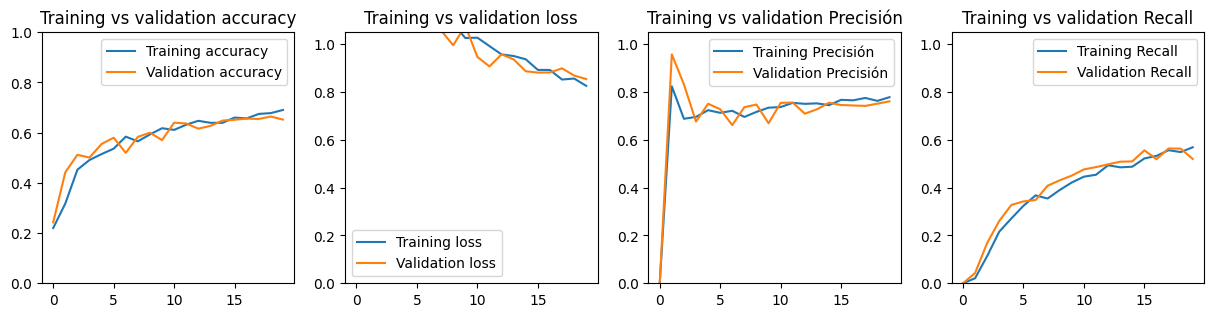

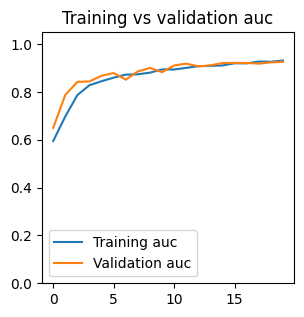

In [ ]:
graph(history_dense)

39/39 [==============================] - 12s 309ms/step


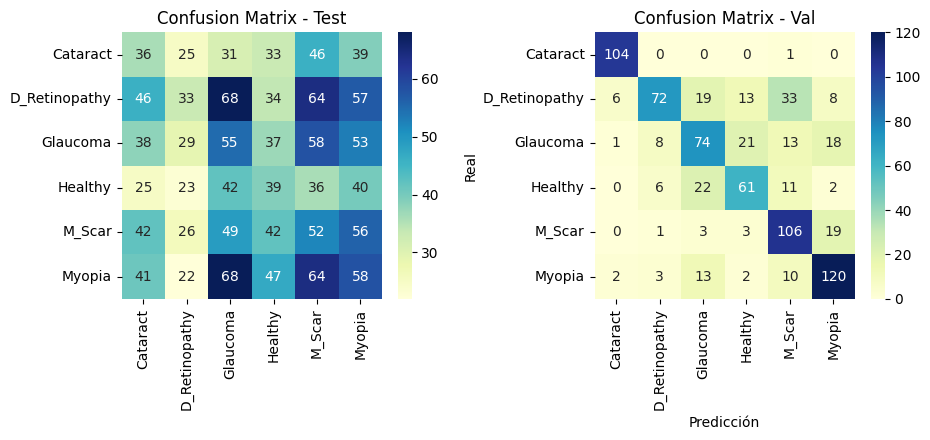

In [ ]:
y_pred_test = model20.predict(test_generator)
y_pred_val = model20.predict(validation_generator)
cf_matrix(y_pred_test, test_generator.classes, y_pred_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model20, y_pred_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model20, y_pred_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.16      0.17      0.16       210
           1       0.21      0.11      0.14       302
           2       0.18      0.20      0.19       270
           3       0.17      0.19      0.18       205
           4       0.16      0.19      0.18       267
           5       0.19      0.19      0.19       300

    accuracy                           0.18      1554
   macro avg       0.18      0.18      0.17      1554
weighted avg       0.18      0.18      0.17      1554

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       105
           1       0.80      0.48      0.60       151
           2       0.56      0.55      0.56       135
           3       0.61      0.60      0.60       102
           4       0.61      0.80      0.69       132
           5       0.72      0.80      0.76       150

    accuracy                           0.69       775
   macro avg       0.70

## Modelo 19

In [ ]:
model19 = Sequential()
model19.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model19.add(MaxPooling2D())
model19.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model19.add(MaxPooling2D())
model19.add(Conv2D(64, kernel_size=(2, 2), activation='relu'))
model19.add(MaxPooling2D())
model19.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model19.add(MaxPooling2D())
model19.add(Conv2D(32, kernel_size=(2, 2), activation='relu'))
model19.add(MaxPooling2D())
model19.add(Flatten())
model19.add(Dense(2056, activation = 'relu'))
model19.add(Dropout(0.75))
model19.add(Dense(1024, activation = 'relu'))
model19.add(Dense(512, activation = 'relu'))
model19.add(Dropout(0.15))
model19.add(Dense(256, activation = 'relu'))
model19.add(Dense(128, activation = 'relu'))
model19.add(Dense(6, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compilar el modelo
model19.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history19 = model19.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=25, callbacks=callback)

Epoch 1/25
150/150 [==============================] - 104s 656ms/step - loss: 1.7485 - accuracy: 0.2055 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5752 - val_loss: 1.6999 - val_accuracy: 0.2947 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6417
Epoch 2/25
150/150 [==============================] - 118s 786ms/step - loss: 1.6813 - accuracy: 0.2697 - precision: 0.5263 - recall: 0.0067 - auc: 0.6468 - val_loss: 1.4946 - val_accuracy: 0.3578 - val_precision: 0.7663 - val_recall: 0.0907 - val_auc: 0.7454
Epoch 3/25
150/150 [==============================] - 100s 665ms/step - loss: 1.5216 - accuracy: 0.3656 - precision: 0.7885 - recall: 0.0872 - auc: 0.7348 - val_loss: 1.3792 - val_accuracy: 0.4003 - val_precision: 0.8756 - val_recall: 0.1223 - val_auc: 0.7862
Epoch 4/25
150/150 [==============================] - 101s 676ms/step - loss: 1.3918 - accuracy: 0.4277 - precision: 0.7490 - recall: 0.1263 - auc: 0.7873 - val_loss: 1.2357 - val_accuracy: 0.4897 - val_p

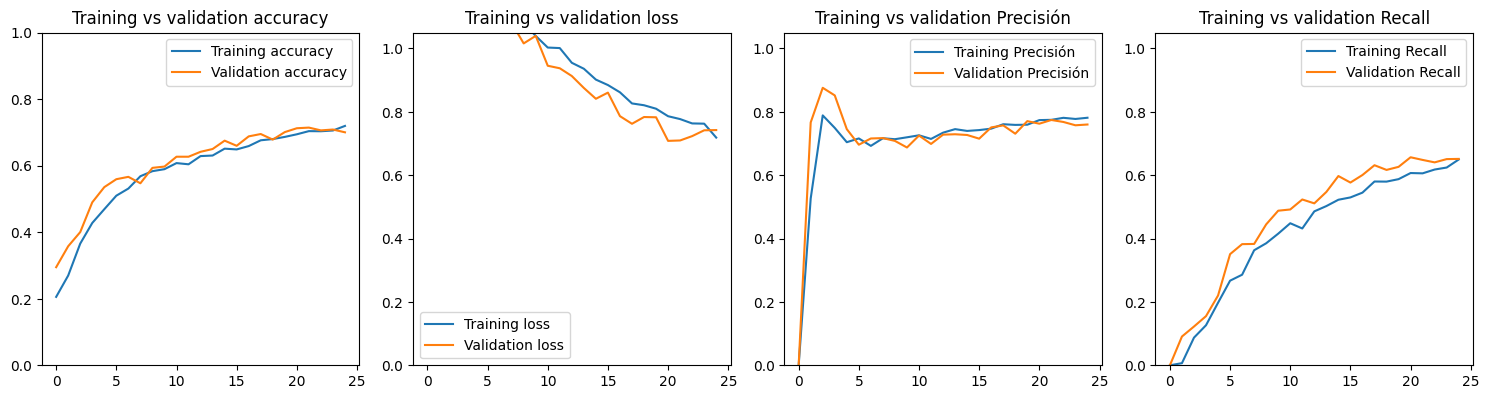

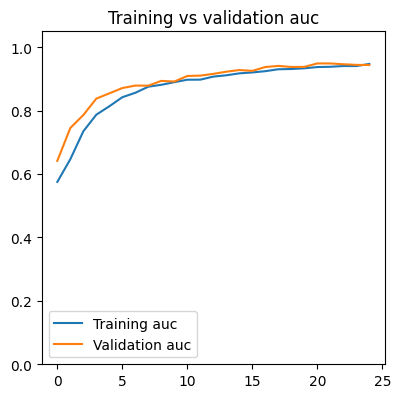

In [ ]:
graph(history19)

39/39 [==============================] - 11s 295ms/step


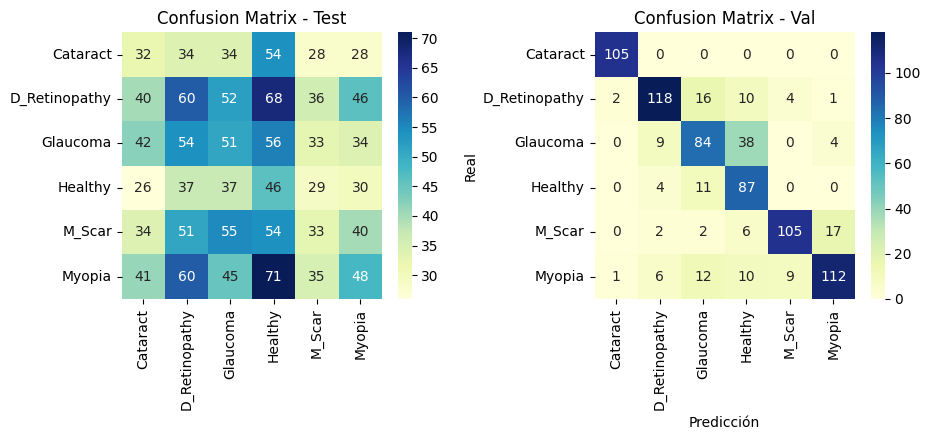

In [ ]:
y_pred19_test = model19.predict(test_generator)
y_pred19_val = model19.predict(validation_generator)
cf_matrix(y_pred19_test, test_generator.classes, y_pred19_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model19, y_pred19_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model19, y_pred19_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.15      0.15      0.15       210
           1       0.20      0.20      0.20       302
           2       0.19      0.19      0.19       270
           3       0.13      0.22      0.17       205
           4       0.17      0.12      0.14       267
           5       0.21      0.16      0.18       300

    accuracy                           0.17      1554
   macro avg       0.18      0.17      0.17      1554
weighted avg       0.18      0.17      0.17      1554

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       105
           1       0.85      0.78      0.81       151
           2       0.67      0.62      0.65       135
           3       0.58      0.85      0.69       102
           4       0.89      0.80      0.84       132
           5       0.84      0.75      0.79       150

    accuracy                           0.79       775
   macro avg       0.80

# Evaluación

Para todos los modelos utilizados se evalua su capacidad de predicción para Entrenamiento, Validación y Prueba

In [ ]:
evaluar_modelo(model1)

Evaluar con Entrenamiento:
272/272 [==============================] - 127s 466ms/step - loss: 0.6710 - accuracy: 0.7347 - precision: 0.7872 - recall: 0.6771 - auc: 0.9536
Evaluar con Validación:
78/78 [==============================] - 22s 279ms/step - loss: 0.7444 - accuracy: 0.6905 - precision: 0.7441 - recall: 0.6532 - auc: 0.9446
Evaluar con Prueba:
39/39 [==============================] - 11s 299ms/step - loss: 0.5937 - accuracy: 0.7832 - precision: 0.8148 - recall: 0.7381 - auc: 0.9635


In [ ]:
evaluar_modelo(model4)

Evaluar con Entrenamiento:
272/272 [==============================] - 126s 462ms/step - loss: 0.6040 - accuracy: 0.7640 - precision: 0.8166 - recall: 0.7049 - auc: 0.9625
Evaluar con Validación:
78/78 [==============================] - 23s 294ms/step - loss: 0.6909 - accuracy: 0.7477 - precision: 0.7836 - recall: 0.6943 - auc: 0.9514
Evaluar con Prueba:
39/39 [==============================] - 11s 282ms/step - loss: 0.6025 - accuracy: 0.7716 - precision: 0.8049 - recall: 0.7135 - auc: 0.9615


In [ ]:
evaluar_modelo(model5)

Evaluar con Entrenamiento:
272/272 [==============================] - 121s 445ms/step - loss: 0.5262 - accuracy: 0.7916 - precision: 0.8513 - recall: 0.7218 - auc: 0.9716
Evaluar con Validación:
78/78 [==============================] - 22s 279ms/step - loss: 0.6857 - accuracy: 0.7497 - precision: 0.7945 - recall: 0.6840 - auc: 0.9534
Evaluar con Prueba:
39/39 [==============================] - 11s 285ms/step - loss: 0.5529 - accuracy: 0.8129 - precision: 0.8480 - recall: 0.7484 - auc: 0.9683


In [ ]:
evaluar_modelo(model15)

Evaluar con Entrenamiento:
272/272 [==============================] - 125s 459ms/step - loss: 0.6468 - accuracy: 0.7366 - precision: 0.7739 - recall: 0.6970 - auc: 0.9578
Evaluar con Validación:
78/78 [==============================] - 21s 269ms/step - loss: 0.7382 - accuracy: 0.7175 - precision: 0.7442 - recall: 0.6815 - auc: 0.9483
Evaluar con Prueba:
39/39 [==============================] - 11s 274ms/step - loss: 0.6266 - accuracy: 0.7484 - precision: 0.7799 - recall: 0.7226 - auc: 0.9609


In [ ]:
evaluar_modelo(model16)

Evaluar con Entrenamiento:
272/272 [==============================] - 126s 461ms/step - loss: 0.5290 - accuracy: 0.7957 - precision: 0.8499 - recall: 0.7307 - auc: 0.9720
Evaluar con Validación:
78/78 [==============================] - 21s 269ms/step - loss: 0.6480 - accuracy: 0.7516 - precision: 0.8035 - recall: 0.7027 - auc: 0.9573
Evaluar con Prueba:
39/39 [==============================] - 11s 274ms/step - loss: 0.4806 - accuracy: 0.8155 - precision: 0.8549 - recall: 0.7600 - auc: 0.9761


In [ ]:
evaluar_modelo(model6)

Evaluar con Entrenamiento:
272/272 [==============================] - 125s 459ms/step - loss: 0.6141 - accuracy: 0.7743 - precision: 0.8220 - recall: 0.7202 - auc: 0.9610
Evaluar con Validación:
78/78 [==============================] - 22s 276ms/step - loss: 0.7044 - accuracy: 0.7317 - precision: 0.7808 - recall: 0.6898 - auc: 0.9498
Evaluar con Prueba:
39/39 [==============================] - 11s 277ms/step - loss: 0.5857 - accuracy: 0.7974 - precision: 0.8326 - recall: 0.7445 - auc: 0.9652


In [ ]:
evaluar_modelo(model19)

Evaluar con Entrenamiento:
272/272 [==============================] - 131s 481ms/step - loss: 0.6895 - accuracy: 0.7360 - precision: 0.7960 - recall: 0.6767 - auc: 0.9515
Evaluar con Validación:
78/78 [==============================] - 24s 304ms/step - loss: 0.7422 - accuracy: 0.7001 - precision: 0.7598 - recall: 0.6512 - auc: 0.9440
Evaluar con Prueba:
39/39 [==============================] - 12s 302ms/step - loss: 0.5700 - accuracy: 0.7884 - precision: 0.8319 - recall: 0.7406 - auc: 0.9666


In [ ]:
evaluar_modelo(model20)

Evaluar con Entrenamiento:
272/272 [==============================] - 132s 484ms/step - loss: 0.8348 - accuracy: 0.6756 - precision: 0.7840 - recall: 0.5331 - auc: 0.9305
Evaluar con Validación:
78/78 [==============================] - 25s 316ms/step - loss: 0.8540 - accuracy: 0.6519 - precision: 0.7608 - recall: 0.5199 - auc: 0.9261
Evaluar con Prueba:
39/39 [==============================] - 11s 299ms/step - loss: 0.7394 - accuracy: 0.6929 - precision: 0.7957 - recall: 0.5729 - auc: 0.9457
